In [1]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import json
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kranoknv/Videos/Violent_00481.mp4
/kaggle/input/kranoknv/Videos/Normal_02850.mp4
/kaggle/input/kranoknv/Videos/Normal_02288.mp4
/kaggle/input/kranoknv/Videos/Normal_00611.mp4
/kaggle/input/kranoknv/Videos/Normal_02813.mp4
/kaggle/input/kranoknv/Videos/Violent_00328.mp4
/kaggle/input/kranoknv/Videos/Normal_00955.mp4
/kaggle/input/kranoknv/Videos/Normal_02145.mp4
/kaggle/input/kranoknv/Videos/Violent_00043.mp4
/kaggle/input/kranoknv/Videos/Normal_01287.mp4
/kaggle/input/kranoknv/Videos/Normal_00268.mp4
/kaggle/input/kranoknv/Videos/Normal_00968.mp4
/kaggle/input/kranoknv/Videos/Normal_02830.mp4
/kaggle/input/kranoknv/Videos/Normal_02077.mp4
/kaggle/input/kranoknv/Videos/Normal_01935.mp4
/kaggle/input/kranoknv/Videos/Normal_01794.mp4
/kaggle/input/kranoknv/Videos/Normal_01105.mp4
/kaggle/input/kranoknv/Videos/Normal_02755.mp4
/kaggle/input/kranoknv/Videos/Violent_00400.mp4
/kaggle/input/kranoknv/Videos/Normal_00626.mp4
/kaggle/input/kranoknv/Videos/Normal_02399.mp4
/kaggle/i

In [2]:
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

2024-06-17 17:42:05.873089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 17:42:05.873196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 17:42:05.987733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
annotations_path = '/kaggle/input/kranoknv/Annotations'
video_path = '/kaggle/input/kranoknv/Videos'

# Eda

In [4]:
# Function to load annotations
def load_annotations(annotations_path):
    annotations = []
    for file_name in os.listdir(annotations_path):
        if file_name.endswith('.json'):
            file_path = os.path.join(annotations_path, file_name)
            with open(file_path, 'r') as f:
                data = json.load(f)
                for frame, frame_data in data.items():
                    frame_number = int(frame.split('_')[-1])  # 'Frame_0000046' -> 46
                    number_of_people = frame_data['numberOfPeople']
                    for pedestrian_data in frame_data['pedestriansData']:
                        try:
                            bbox = list(map(int, pedestrian_data[:4]))  # Convert bbox coordinates to integers
                            behavior = pedestrian_data[4]
                        except KeyError as e:
                            print(f"Missing key {e} in annotation for frame {frame_number} in file {file_name}")
                            continue

                        annotations.append({
                            'video': file_name,
                            'frame': frame_number,
                            'num_pedestrians': number_of_people,
                            'bbox': bbox,
                            'behavior': behavior
                        })
    return pd.DataFrame(annotations)

# Load annotations into a DataFrame
annotations_df = load_annotations(annotations_path)

# Display the first few rows of the DataFrame
print(annotations_df.head())


               video  frame  num_pedestrians                 bbox behavior
0  Normal_00409.json     46                1  [503, 58, 566, 174]   Normal
1  Normal_00409.json     58                1  [415, 61, 471, 171]   Normal
2  Normal_00409.json     99                1  [225, 76, 266, 147]   Normal
3  Normal_00409.json     62                1  [383, 62, 446, 168]   Normal
4  Normal_00409.json      4                1  [744, 54, 793, 168]   Normal


* **video**: Videonun adı. Örneğin, Normal_00409.json dosyasının adı bu videonun "Normal" olarak etiketlendiğini ve belirli bir numara (00409) ile tanımlandığını gösterir.
* **frame**: Çerçeve numarası. Bu, videodaki hangi kareye ait olduğunun numarasını gösterir.
* **num_pedestrians**: O karede bulunan pedestrian (yaya) sayısı. Örnekte her zaman 1 değeri var, yani her karede sadece bir yaya var.
* **bbox**: Bounding box koordinatları. Bu, pedestrian'ın görüntüde kapladığı alanı gösterir ve [x_min, y_min, x_max, y_max] formatında verilmiştir. Bu değerler, pedestrian'ın sol üst ve sağ alt köşe koordinatlarını belirtir.
* **behavior**: Yaya davranışı. Bu örnekte her zaman Normal olarak belirtilmiş, yani bu karelerde görülen pedestrian normal davranış sergiliyor.

In [5]:
annotations_df

,video,frame,num_pedestrians,bbox,behavior
0,Normal_00409.json,46,1,"[503, 58, 566, 174]",Normal
1,Normal_00409.json,58,1,"[415, 61, 471, 171]",Normal
2,Normal_00409.json,99,1,"[225, 76, 266, 147]",Normal
3,Normal_00409.json,62,1,"[383, 62, 446, 168]",Normal
4,Normal_00409.json,4,1,"[744, 54, 793, 168]",Normal
...,...,...,...,...,...
1021776,Normal_02346.json,32,2,"[778, 54, 809, 147]",Normal
1021777,Normal_02346.json,32,2,"[814, 74, 839, 152]",Normal
1021778,Normal_02346.json,30,2,"[781, 54, 811, 145]",Normal
1021779,Normal_02346.json,30,2,"[814, 74, 839, 152]",Normal


In [6]:
annotations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021781 entries, 0 to 1021780
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   video            1021781 non-null  object
 1   frame            1021781 non-null  int64 
 2   num_pedestrians  1021781 non-null  int64 
 3   bbox             1021781 non-null  object
 4   behavior         1021781 non-null  object
dtypes: int64(2), object(3)
memory usage: 39.0+ MB


behavior
Normal     703358
Violent    318423
Name: count, dtype: int64


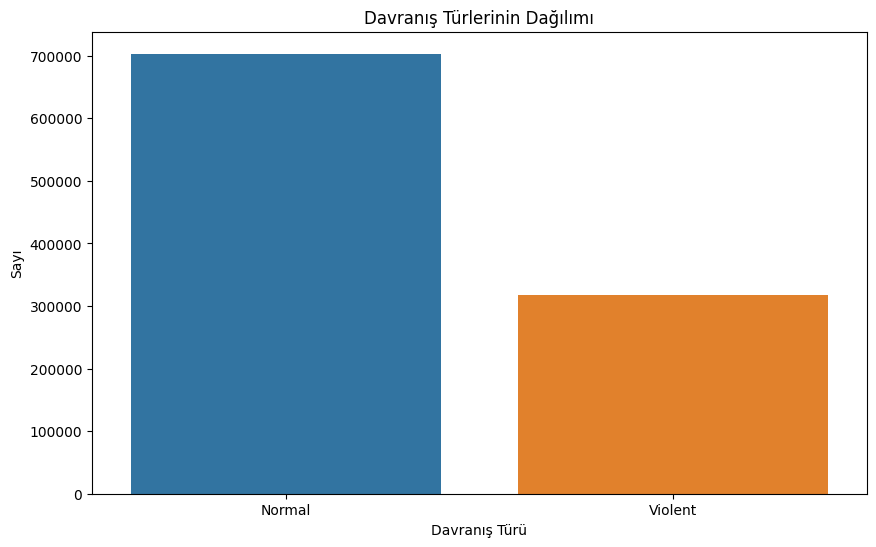

In [7]:
behavior_counts = annotations_df['behavior'].value_counts()
print(behavior_counts)

plt.figure(figsize=(10, 6))
sns.countplot(data=annotations_df, x='behavior', order=behavior_counts.index)
plt.title('Davranış Türlerinin Dağılımı')
plt.xlabel('Davranış Türü')
plt.ylabel('Sayı')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


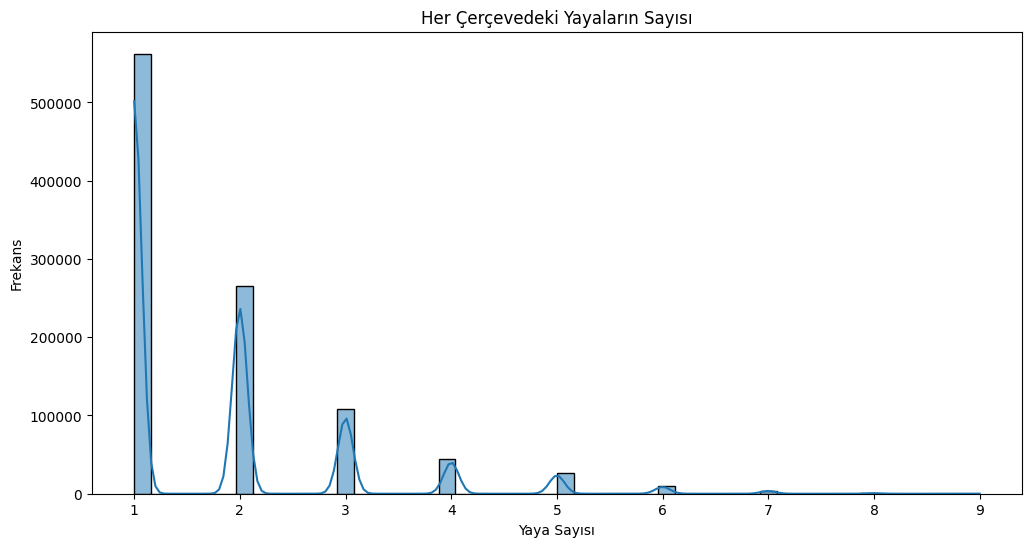

In [8]:
# pedestrians number for each frame
plt.figure(figsize=(12, 6))
sns.histplot(annotations_df['num_pedestrians'], bins=50, kde=True)
plt.title('Her Çerçevedeki Yayaların Sayısı')
plt.xlabel('Yaya Sayısı')
plt.ylabel('Frekans')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


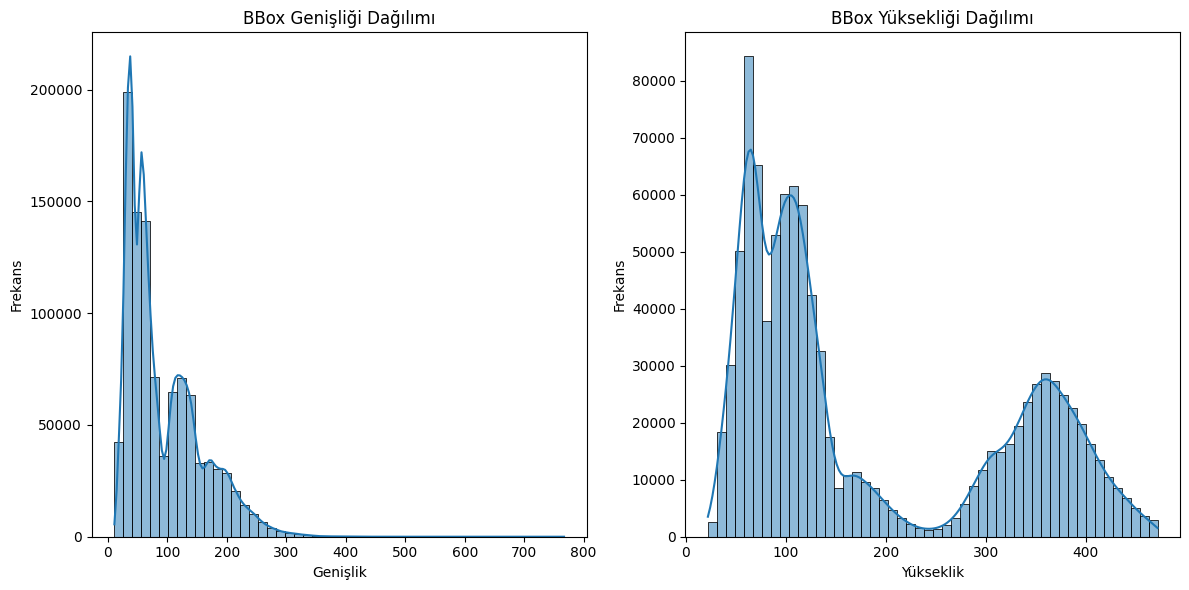

In [9]:
annotations_df['bbox_width'] = annotations_df['bbox'].apply(lambda x: int(x[2]) - int(x[0]))
annotations_df['bbox_height'] = annotations_df['bbox'].apply(lambda x: int(x[3]) - int(x[1]))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(annotations_df['bbox_width'], bins=50, kde=True)
plt.title('BBox Genişliği Dağılımı')
plt.xlabel('Genişlik')
plt.ylabel('Frekans')

plt.subplot(1, 2, 2)
sns.histplot(annotations_df['bbox_height'], bins=50, kde=True)
plt.title('BBox Yüksekliği Dağılımı')
plt.xlabel('Yükseklik')
plt.ylabel('Frekans')

plt.tight_layout()
plt.show()

In [10]:
print(annotations_df.describe())

              frame  num_pedestrians    bbox_width   bbox_height
count  1.021781e+06     1.021781e+06  1.021781e+06  1.021781e+06
mean   5.073936e+02     1.783452e+00  9.282732e+01  1.846171e+02
std    1.201758e+03     1.138867e+00  6.200204e+01  1.311804e+02
min    1.000000e+00     1.000000e+00  1.100000e+01  2.200000e+01
25%    6.000000e+01     1.000000e+00  4.300000e+01  7.600000e+01
50%    1.530000e+02     1.000000e+00  6.900000e+01  1.190000e+02
75%    4.810000e+02     2.000000e+00  1.310000e+02  3.300000e+02
max    1.488400e+04     9.000000e+00  7.670000e+02  4.720000e+02


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

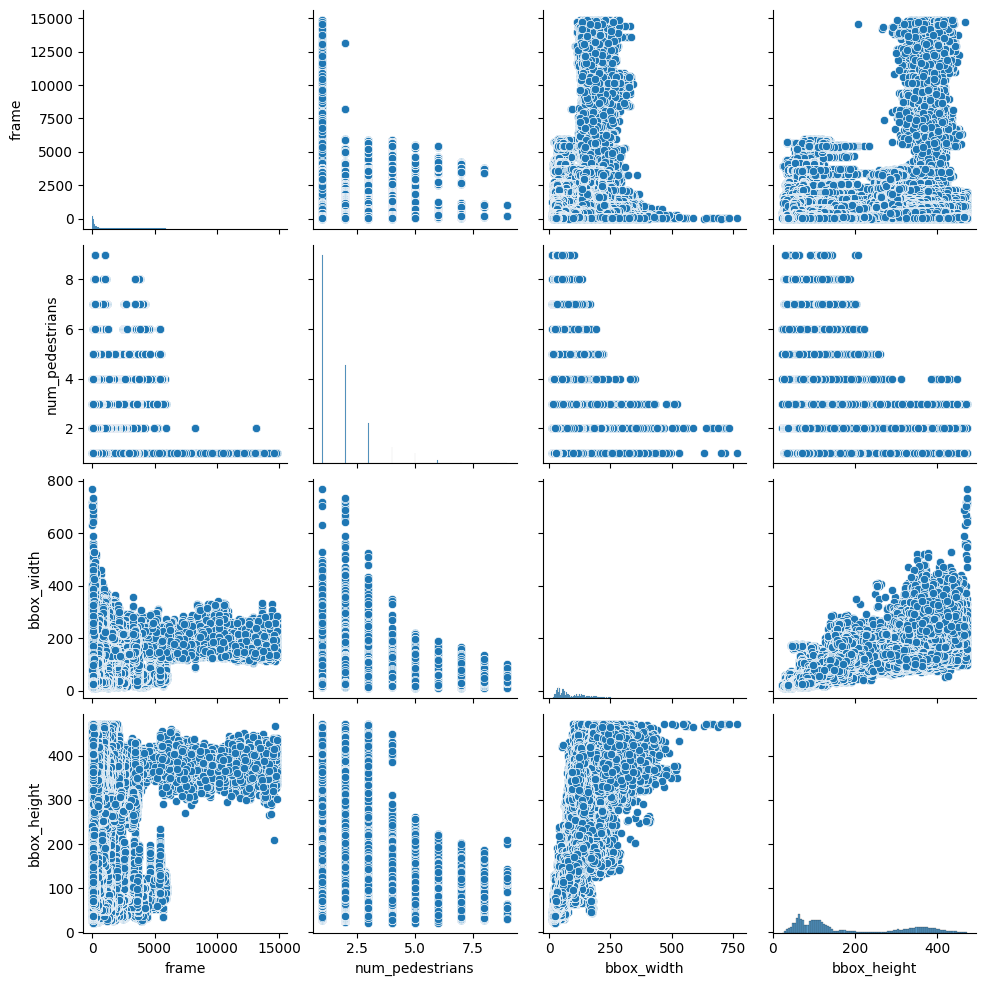

In [11]:
sns.pairplot(annotations_df[['frame', 'num_pedestrians', 'bbox_width', 'bbox_height']])
plt.show()

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Function to process bbox and calculate area
def process_bbox(bbox):
    if isinstance(bbox, str):
        bbox = eval(bbox)  # Convert string representation to list
    # Calculate width and height
    width = bbox[2] - bbox[0]
    height = bbox[3] - bbox[1]
    # Calculate area
    area = width * height
    return area

annotations_df['bbox_area'] = annotations_df['bbox'].apply(process_bbox)

# Select features including bbox_area
X = annotations_df[['frame', 'num_pedestrians', 'bbox_area']]
y = annotations_df['behavior']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Example of predicting with new data
new_data = {
    'frame': [30],
    'num_pedestrians': [2],
    'bbox_area': [3000]  # Example value, replace with actual feature engineering
}
new_df = pd.DataFrame(new_data)
predicted_behavior = model.predict(new_df)
print("Predicted behavior:", predicted_behavior)


              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99    140921
     Violent       0.97      0.97      0.97     63436

    accuracy                           0.98    204357
   macro avg       0.98      0.98      0.98    204357
weighted avg       0.98      0.98      0.98    204357

Predicted behavior: ['Normal']


In [13]:
annotations_df.to_csv("annotations_df")